In [1]:
'''@author: Zi Xian Leong (zxleong@psu.edu) '''

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from random import uniform as rand
import scipy.io as sio
import os
from sklearn.model_selection import train_test_split
from skimage.transform import rescale, resize
from sklearn.metrics import accuracy_score
from sklearn import preprocessing as pp

from numpy.matlib import repmat

from sklearn.metrics import r2_score, mean_squared_error
import pandas as pd
import scipy.ndimage.filters as fil
from keras import backend as K
# from skimage.metrics import structural_similarity as ssim
from matplotlib.ticker import FormatStrFormatter
from scipy.signal import savgol_filter
# from mpl_toolkits.mplot3d import Axes3D  
import seaborn as sns
from sklearn.metrics import r2_score
from tqdm import tqdm
import scipy.stats
from scipy.signal import tukey
from matplotlib.ticker import FormatStrFormatter
import string
from DLcodes.GPRNet import GPRNet

Using TensorFlow backend.


## Part 1

## Process raw 2D common-offset data

In [2]:
xTest_gt_raw = sio.loadmat('Synthetic/Data/2D/fdraw_2D.mat')['co_data']
xTest_gt_raw.shape

(1280, 251)

In [3]:
def taper(in_array):
    '''Removes the first arrival'''
    window = tukey(1280,0.4)
    window[600:len(window)]=1
    window = window**4
    out = in_array * window
    return out

xTest_gt = np.apply_along_axis(taper,0,xTest_gt_raw)
xTest_gt = pp.normalize(xTest_gt,norm='max',axis=0)
xTest_gt = np.expand_dims(xTest_gt.T,axis=2)
xTest_gt.shape

#np.save('Synthetic/Data/2D/xTest2D_img.npy',xTest_gt)

(251, 1280, 1)

## Using previously trained 1D library to predict on the 2D image

In [4]:
weights_path = 'Synthetic/Weights/weight_GPRNet_n16k20.h5'

cnn_model = GPRNet(im_width=1, im_height=1280, neurons=16, kern_sz = 20,enable_dropout=False) #use this
cnn_model.load_weights(weights_path)

ypred_2D = np.squeeze(cnn_model.predict(xTest_gt),axis=2)

# np.save('Data/2D/ypred2D.npy')

Instructions for updating:
Colocations handled automatically by placer.


## Compare Predictions vs GT

In [5]:
ypred_2D = np.load('Synthetic/Data/2D/ypred2D.npy').T
yTrue_2D = np.load('Synthetic/Data/2D/yTrue2D_vel_td.npy')

In [6]:
print(ypred_2D.shape)
print(yTrue_2D.shape)

(1280, 251)
(1280, 251)


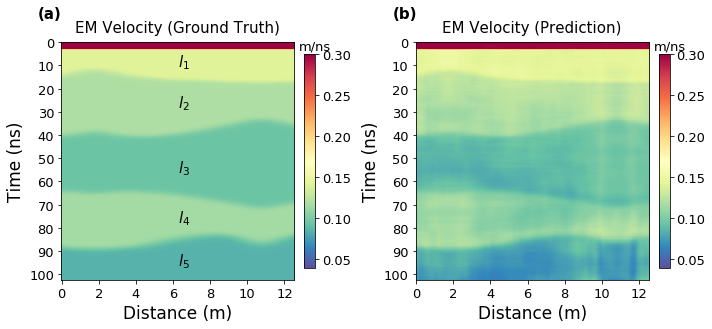

In [7]:
def compare_prediction():
    fig,axs = plt.subplots(1,2,figsize=(10,18))
    xylabelfontsize=17
    tickfontsize=13
    titlefontsize=15
    titlepadsize = 10
    subtitlesfontsize = 15
    subtitlesPos = [-0.1,1.1]
    matplotlib.rcdefaults()
    
    
    ax = axs[0]
    im = ax.imshow(yTrue_2D/1e9,cmap='Spectral_r',vmin=0.04,vmax=0.3)
    ax.set_xlabel('Distance (m)', fontsize=xylabelfontsize)
    ax.set_xticks(np.arange(0,251,40)) #dx is 0.05, so 20 cell is 1m
    ax.set_xticklabels(np.arange(0,13,2),fontsize=tickfontsize)
    ax.set_ylabel('Time (ns)', fontsize=xylabelfontsize)
    ax.set_aspect(aspect=0.2)
    ax.set_yticks(np.arange(0,1300,125)) #dt is 8e-11
    ax.set_yticklabels(np.arange(0,110,10),fontsize=tickfontsize)
    cbar = plt.colorbar(im, ax=ax,fraction=0.042, pad=0.04)
    cbar.ax.tick_params(labelsize=tickfontsize) 
    cbar.ax.set_xlabel('m/ns',fontsize=tickfontsize)
    cbar.ax.xaxis.set_label_coords(1,1.07)
    ax.set_title('EM Velocity (Ground Truth)',fontsize=titlefontsize, pad=titlepadsize)
    ax.text(subtitlesPos[0],subtitlesPos[1], '('+string.ascii_lowercase[0]+')', transform=ax.transAxes, size=subtitlesfontsize, weight='bold')
    ax.text(125,130,r'$l_1$',fontsize=15)
    ax.text(125,350,r'$l_2$',fontsize=15)
    ax.text(125,700,r'$l_3$',fontsize=15)
    ax.text(125,970,r'$l_4$',fontsize=15)
    ax.text(125,1200,r'$l_5$',fontsize=15)
        
    ax2 = axs[1]
    im2 = ax2.imshow(ypred_2D/1e9,cmap='Spectral_r',vmin=0.04,vmax=0.3)
    ax2.set_xlabel('Distance (m)', fontsize=xylabelfontsize)
    ax2.set_xticks(np.arange(0,251,40)) #dx is 0.05, so 20 cell is 1m
    ax2.set_xticklabels(np.arange(0,13,2),fontsize=tickfontsize)
    ax2.set_ylabel('Time (ns)', fontsize=xylabelfontsize)
    ax2.set_aspect(aspect=0.2)
    ax2.set_yticks(np.arange(0,1300,125)) #dt is 8e-11
    ax2.set_yticklabels(np.arange(0,110,10),fontsize=tickfontsize)
    cbar2 = plt.colorbar(im2, ax=ax2,fraction=0.042, pad=0.04)
    cbar2.ax.tick_params(labelsize=tickfontsize) 
    cbar2.ax.set_xlabel('m/ns',fontsize=tickfontsize)
    cbar2.ax.xaxis.set_label_coords(1,1.07)
    ax2.set_title('EM Velocity (Prediction)',fontsize=titlefontsize,pad=titlepadsize)
    ax2.text(subtitlesPos[0],subtitlesPos[1], '('+string.ascii_lowercase[1]+')', transform=ax2.transAxes, size=subtitlesfontsize, weight='bold')

    fig.tight_layout()

compare_prediction()

## Part 2

## Create forward data based on (b), then compare it to the original synthetic data

In [25]:
'''Convert (b) from time depth (ns) to spatial domain (m), then simulate forward common-offset data'''
from scipy.interpolate import interp1d

# ypred_2D (1280,251)


#convert to depth domain
n = ypred_2D.shape[1] #number of shots
dt=8e-11
ypred_2D_dd = []
z_stack_length = []
for i in range(n):
    vel_line = ypred_2D[:,i]
    depth_z = np.cumsum(vel_line * dt, axis=0) / 2
    depth_z = np.insert(depth_z[:1280-1],0,0,axis=0)
    max_depth = np.max(depth_z)
    dest_depth = np.arange(0,max_depth,0.05)
    vel_dd = interp1d(depth_z, vel_line,kind='linear',bounds_error=False,fill_value=np.nan,axis=0)(dest_depth)
    ypred_2D_dd.append(vel_dd)
    z_stack_length.append(len(dest_depth))
ypred_2D_dd = np.array(ypred_2D_dd)
z_stack_length = np.array(z_stack_length)

#cut to the largest non-NaN
min_z = np.min(z_stack_length)

vel_dd_img_corr = []
for i in range(n):
    vel_line = ypred_2D_dd[i][:min_z]
    vel_dd_img_corr.append(vel_line)
vel_dd_img_corr = np.array(vel_dd_img_corr).T

#add air (as assurance)
vel_dd_img_corr[:10,:] = 299792500

# ep
ep_ypred = 299792500**2 / vel_dd_img_corr **2


#save
# sio.savemat('Synthetic/Data/2D/ep_ypred2D.mat',{'ep':ep_ypred})

## Then  run FD_sim_testingmodel_ypred.m (matlab file) ! This creates the forward data of the prediction

In [27]:
raw_ypred_data = sio.loadmat('Synthetic/Data/2D/fdraw_predicted_data.mat')['co_data']

In [54]:
# xTest_gt = np.load('Synthetic/Data/2D/xTest2D_img.npy')


In [28]:
def taper(in_array):
    window = tukey(1280,0.4)
    window[600:len(window)]=1
    window = window**4
    out = in_array * window
    return out


ypred_data = np.apply_along_axis(taper,0,raw_ypred_data)
ypred_data = pp.normalize(ypred_data,norm='max',axis=0)

In [29]:
ypred_data.shape

(1280, 251)

## Put all the figures together (Figure 5)

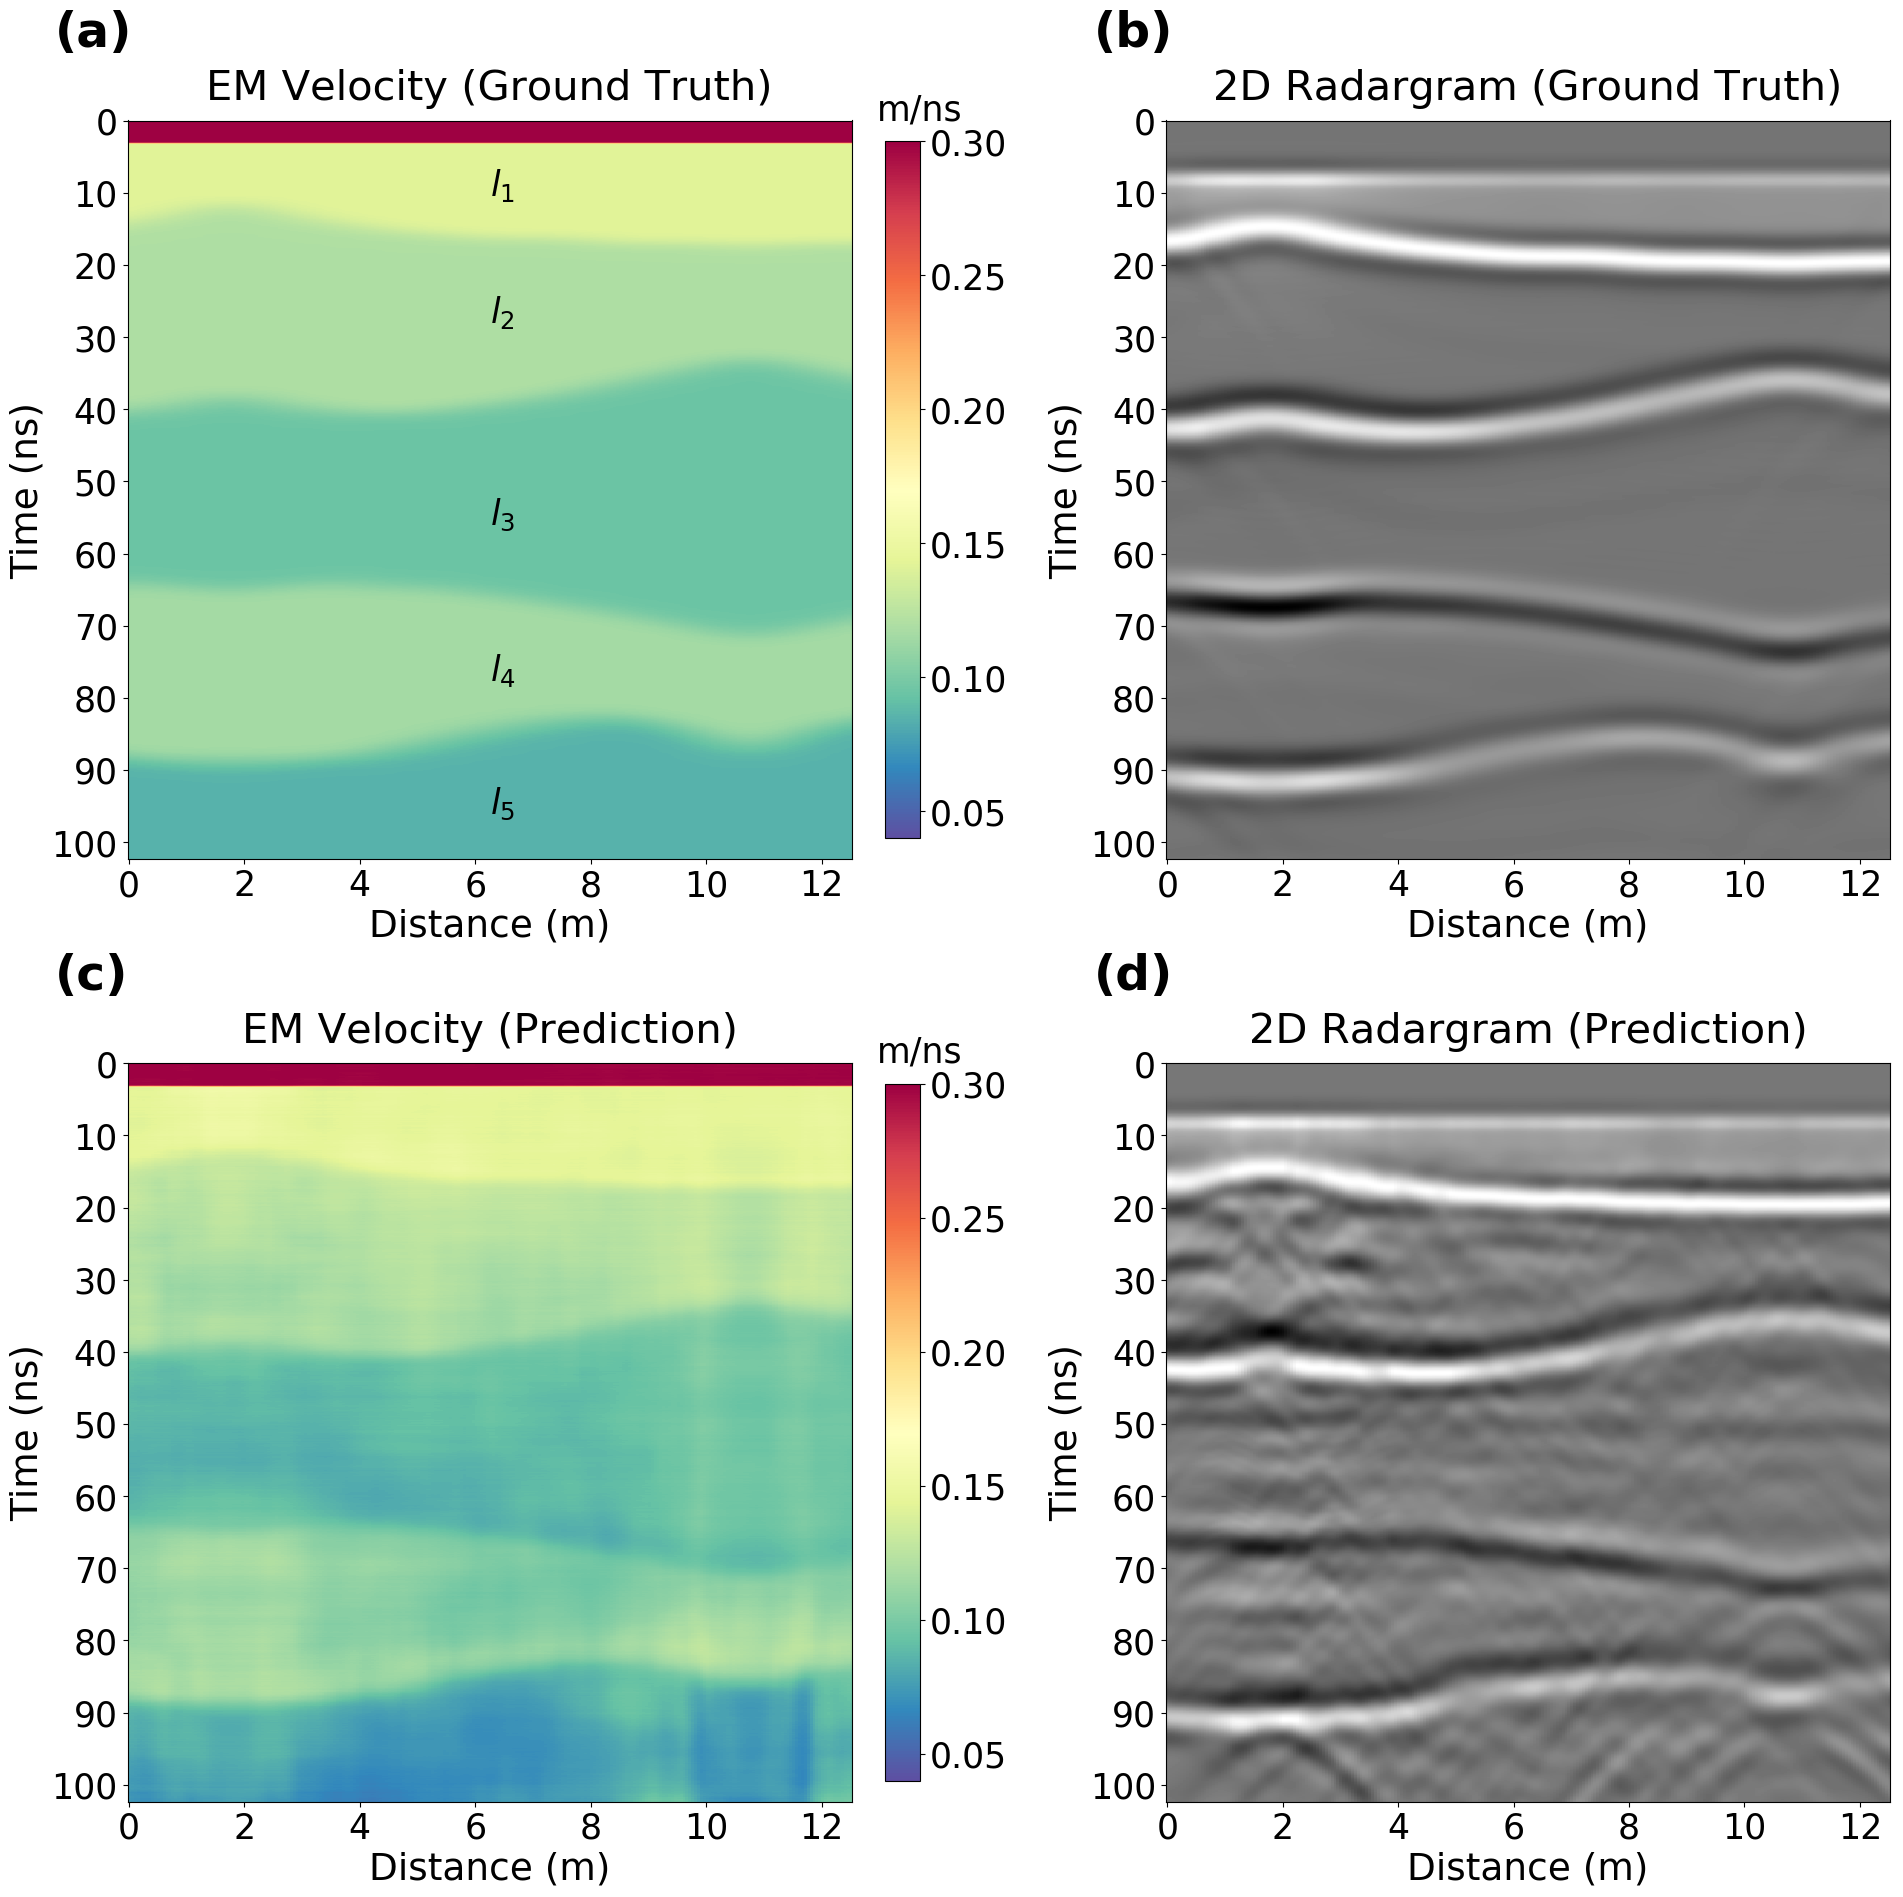

In [32]:
def figure5():
    fig,axs = plt.subplots(2,2,figsize=(20,19))
    xylabelfontsize=27
    tickfontsize=25
    titlefontsize=30
    titlepadsize = 15
    subtitlesfontsize = 35
    subtitlesPos = [-0.1,1.1]
    matplotlib.rcdefaults()
    
    
    ax = axs[0,0]
    im = ax.imshow(yTrue_2D/1e9,cmap='Spectral_r',vmin=0.04,vmax=0.3)
    ax.set_xlabel('Distance (m)', fontsize=xylabelfontsize)
    ax.set_xticks(np.arange(0,251,40)) #dx is 0.05, so 20 cell is 1m
    ax.set_xticklabels(np.arange(0,13,2),fontsize=tickfontsize)
    ax.set_ylabel('Time (ns)', fontsize=xylabelfontsize)
    ax.set_aspect(aspect=0.2)
    ax.set_yticks(np.arange(0,1300,125)) #dt is 8e-11
    ax.set_yticklabels(np.arange(0,110,10),fontsize=tickfontsize)
    cbar = plt.colorbar(im, ax=ax,fraction=0.042, pad=0.04)
    cbar.ax.tick_params(labelsize=tickfontsize) 
    cbar.ax.set_xlabel('m/ns',fontsize=tickfontsize)
    cbar.ax.xaxis.set_label_coords(1,1.07)
    ax.set_title('EM Velocity (Ground Truth)',fontsize=titlefontsize, pad=titlepadsize)
    ax.text(subtitlesPos[0],subtitlesPos[1], '('+string.ascii_lowercase[0]+')', transform=ax.transAxes, size=subtitlesfontsize, weight='bold')
    ax.text(125,130,r'$l_1$',fontsize=25)
    ax.text(125,350,r'$l_2$',fontsize=25)
    ax.text(125,700,r'$l_3$',fontsize=25)
    ax.text(125,970,r'$l_4$',fontsize=25)
    ax.text(125,1200,r'$l_5$',fontsize=25)
    
    ax2 = axs[0,1]
    ax2.imshow(xTest_gt[:,:,0].T,cmap='gray')
    ax2.set_xlabel('Distance (m)',fontsize=xylabelfontsize)
    ax2.set_ylabel('Time (ns)',fontsize=xylabelfontsize)
    ax2.set_yticks(np.arange(0,1300,125)) #dt is 8e-11
    ax2.set_yticklabels(np.arange(0,110,10),fontsize=tickfontsize)
    ax2.set_xticks(np.arange(0,251,40)) #step=every 2m / 0.05
    ax2.set_xticklabels(np.arange(0,13,2),fontsize=tickfontsize)
    ax2.set_title('2D Radargram (Ground Truth)', fontsize=titlefontsize,pad=titlepadsize)
    ax2.set_aspect(aspect=0.2)
    ax2.text(subtitlesPos[0],subtitlesPos[1], '('+string.ascii_lowercase[1]+')', transform=ax2.transAxes, size=subtitlesfontsize, weight='bold')
    
    ax3 = axs[1,0]
    im2 = ax3.imshow(ypred_2D/1e9,cmap='Spectral_r',vmin=0.04,vmax=0.3)
    ax3.set_xlabel('Distance (m)', fontsize=xylabelfontsize)
    ax3.set_xticks(np.arange(0,251,40)) #dx is 0.05, so 20 cell is 1m
    ax3.set_xticklabels(np.arange(0,13,2),fontsize=tickfontsize)
    ax3.set_ylabel('Time (ns)', fontsize=xylabelfontsize)
    ax3.set_aspect(aspect=0.2)
    ax3.set_yticks(np.arange(0,1300,125)) #dt is 8e-11
    ax3.set_yticklabels(np.arange(0,110,10),fontsize=tickfontsize)
    cbar2 = plt.colorbar(im2, ax=ax3,fraction=0.042, pad=0.04)
    cbar2.ax.tick_params(labelsize=tickfontsize) 
    cbar2.ax.set_xlabel('m/ns',fontsize=tickfontsize)
    cbar2.ax.xaxis.set_label_coords(1,1.07)
    ax3.set_title('EM Velocity (Prediction)',fontsize=titlefontsize,pad=titlepadsize)
    ax3.text(subtitlesPos[0],subtitlesPos[1], '('+string.ascii_lowercase[2]+')', transform=ax3.transAxes, size=subtitlesfontsize, weight='bold')
    
    ax4 = axs[1,1]
    ax4.imshow(ypred_data,cmap='gray')
    ax4.set_xlabel('Distance (m)',fontsize=xylabelfontsize)
    ax4.set_ylabel('Time (ns)',fontsize=xylabelfontsize)
    ax4.set_yticks(np.arange(0,1300,125)) #dt is 8e-11
    ax4.set_yticklabels(np.arange(0,110,10),fontsize=tickfontsize)
    ax4.set_xticks(np.arange(0,251,40)) #step=every 2m / 0.05
    ax4.set_xticklabels(np.arange(0,13,2),fontsize=tickfontsize)
    ax4.set_title('2D Radargram (Prediction)', fontsize=titlefontsize,pad=titlepadsize)
    ax4.set_aspect(aspect=0.2)
    ax4.text(subtitlesPos[0],subtitlesPos[1], '('+string.ascii_lowercase[3]+')', transform=ax4.transAxes, size=subtitlesfontsize, weight='bold')
    fig.tight_layout()
    

figure5()

## See few samples of invidual prediction profiles (2m, 6m and 11m) - Figure 6

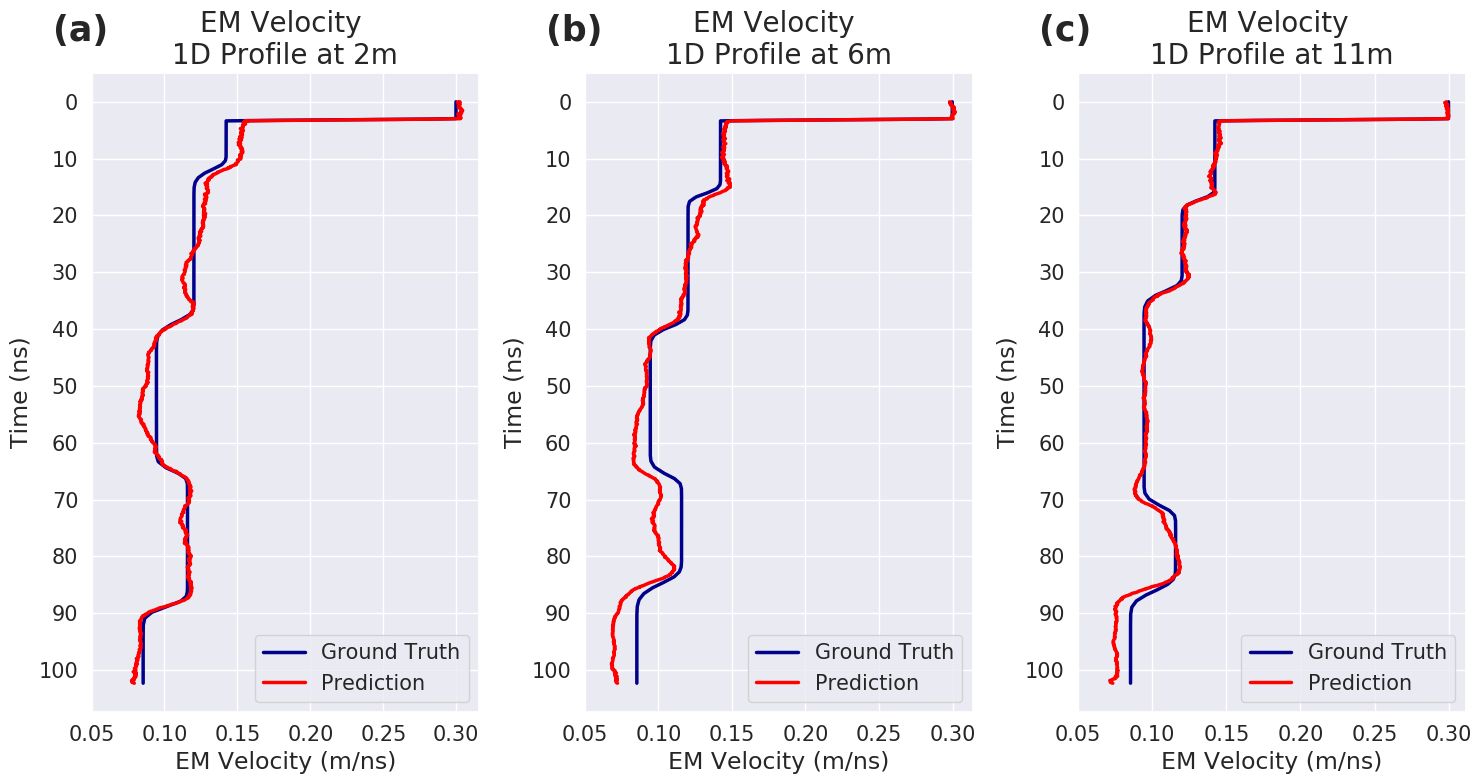

In [33]:
sns.set_theme(style='darkgrid')
def figure6():
    fig,axs = plt.subplots(1,3,figsize=(15,8))
    sns.set_theme(style='darkgrid')
    
    ax = axs[0]
    ind=40
    ax.invert_yaxis()
    ypred_line = ypred_2D[:,ind]/1e9
    ytrue_line = yTrue_2D[:,ind]/1e9
    x = np.arange(1280)
    ax.plot(ytrue_line,x, label='Ground Truth', color='darkblue',linewidth=2.5)
    ax.plot(ypred_line,x, label='Prediction',color='red',linewidth=2.5)
    ax.set_xlabel('EM Velocity (m/ns)', fontsize=17)
    ax.set_ylabel('Time (ns)', fontsize=17)
    ax.set_xticks(np.arange(0.05,0.35,0.05))
    ax.set_xticklabels(np.arange(0.05,0.35,0.05),fontsize=15)
    ax.set_yticks(np.arange(0,1300,125))
    ax.set_yticklabels(np.arange(0,110,10),fontsize=15)
    ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.set_title('EM Velocity \n1D Profile at {}m'.format(round(ind*0.05)),fontsize=20)
    ax.legend(loc=4,fontsize=15)
    ax.text(-0.1, 1.05, '('+string.ascii_lowercase[0]+')', transform=ax.transAxes, size=25, weight='bold')

    
    ax2 = axs[1]
    ind=120
    ax2.invert_yaxis()
    ypred_line = ypred_2D[:,ind]/1e9
    ytrue_line = yTrue_2D[:,ind]/1e9
    x = np.arange(1280)
    ax2.plot(ytrue_line,x, label='Ground Truth', color='darkblue',linewidth=2.5)
    ax2.plot(ypred_line,x, label='Prediction',color='red',linewidth=2.5)
    ax2.set_xlabel('EM Velocity (m/ns)', fontsize=17)
    ax2.set_ylabel('Time (ns)', fontsize=17)
    ax2.set_xticks(np.arange(0.05,0.35,0.05))
    ax2.set_xticklabels(np.arange(0.05,0.35,0.05),fontsize=15)
    ax2.set_yticks(np.arange(0,1300,125))
    ax2.set_yticklabels(np.arange(0,110,10),fontsize=15)
    ax2.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax2.set_title('EM Velocity \n1D Profile at {}m'.format(round(ind*0.05)),fontsize=20)
    ax2.legend(loc=4,fontsize=15)
    ax2.text(-0.1, 1.05, '('+string.ascii_lowercase[1]+')', transform=ax2.transAxes, size=25, weight='bold')

    
    ax3 = axs[2]
    ind=220
    ax3.invert_yaxis()
    ypred_line = ypred_2D[:,ind]/1e9
    ytrue_line = yTrue_2D[:,ind]/1e9
    x = np.arange(1280)
    ax3.plot(ytrue_line,x, label='Ground Truth', color='darkblue',linewidth=2.5)
    ax3.plot(ypred_line,x, label='Prediction',color='red',linewidth=2.5)
    ax3.set_xlabel('EM Velocity (m/ns)', fontsize=17)
    ax3.set_ylabel('Time (ns)', fontsize=17)
    ax3.set_xticks(np.arange(0.05,0.35,0.05))
    ax3.set_xticklabels(np.arange(0.05,0.35,0.05),fontsize=15)
    ax3.set_yticks(np.arange(0,1300,125))
    ax3.set_yticklabels(np.arange(0,110,10),fontsize=15)
    ax3.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax3.set_title('EM Velocity \n1D Profile at {}m'.format(round(ind*0.05)),fontsize=20)
    ax3.legend(loc=4,fontsize=15)
    ax3.text(-0.1, 1.05, '('+string.ascii_lowercase[2]+')', transform=ax3.transAxes, size=25, weight='bold')
    fig.tight_layout()

figure6()

In [47]:
print('R2 score of 2m is',r2_score(yTrue_2D[:,40]/1e9,ypred_2D[:,40]/1e9))
print('R2 score of 6m is',r2_score(yTrue_2D[:,120]/1e9,ypred_2D[:,120]/1e9))
print('R2 score of 11m is',r2_score(yTrue_2D[:,220]/1e9,ypred_2D[:,220]/1e9))


R2 score of 2m is 0.9759940708119207
R2 score of 6m is 0.9304126645836202
R2 score of 11m is 0.9824158072776542
